# Functions and Imports (no user input)

## Package Imports

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
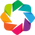

In [1]:
import os
import pandas as pd
import numpy as np
import openpyxl

from scipy import stats
from scipy.stats import linregress
from scipy.interpolate import interp1d

from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, mean_absolute_error

from yellowbrick.cluster import KElbowVisualizer

from datetime import date

import holoviews as hv
import colorcet
# from holoviews.operation import histogram
from bokeh.models import HoverTool
hv.extension('bokeh')

from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D

from IPython.display import SVG


## Ripley's K and L Functions (distribution of data)

In [2]:
import numpy as np
from scipy.spatial import distance

def rescale_data(x):
    min_val = np.min(x)
    max_val = np.max(x)
    return (x - min_val) / (max_val - min_val)

def Ripley_K(x, scale):
    x = rescale_data(x)
    x_pairs = distance.cdist(x, x, 'euclidean')  # All pairwise distances
    return np.sum(x_pairs <= scale) / len(x)

def Ripley_L(x, scale):
    x = rescale_data(x)
    return np.sqrt(Ripley_K(x, scale) / np.pi)

## Define r2_score

In [3]:
# improved definiton of r2_score (https://stats.stackexchange.com/questions/590199/how-to-motivate-the-definition-of-r2-in-sklearn-metrics-r2-score) (scikitlearn uses out-of-sample y_mean)
def r2_score(y_train, y, y_pred):  #y_train and y can be the same if determining r2 for training data (use y_train and y_validation for validation data)
    y_bar = np.mean(y_train)
    RSS = np.sum((y - y_pred)**2)   # Residual Sum of Squares
    TSS = np.sum((y - y_bar)**2)    # Total Sum of Squares
    r2_score = 1 - (RSS / TSS)
    return r2_score

## Determine column name and index during import

In [4]:
## Allow for user to input both name (string) or index number for column headers
def get_column_loc(column, dataframe):
    if isinstance(column, str):
        return dataframe.columns.get_loc(column), column
    else:
        return column, dataframe.columns[column]

## Image generation from SMILES string

In [5]:
# adapted from https://birdlet.github.io/2018/06/06/rdkit_svg_web/
def DrawMol(dataframe, smiles_column_loc, image_column, molSize=(200, 100), kekulize=True):
    images = []
    for smiles_string in dataframe.iloc[:, smiles_column_loc]:
        try:
            mc = Chem.MolFromSmiles(smiles_string)
            if kekulize:
                try:
                    Chem.Kekulize(mc)
                except:
                    mc = Chem.Mol(smiles_string.ToBinary())

            if not mc.GetNumConformers():
                Chem.rdDepictor.Compute2DCoords(mc)

            drawer = rdMolDraw2D.MolDraw2DSVG(*molSize)
            drawer.DrawMolecule(mc)
            drawer.FinishDrawing()
            svg = drawer.GetDrawingText().replace('svg:', '')
            images.append(SVG(svg).data)
        except:
            images.append(None)
    
    try:
        dataframe.insert(smiles_column_loc+1, image_column, images)
    except: #  reason for error 
        dataframe[image_column] = images
        
    return dataframe

## HoloViews

In [6]:
def scatter_plot(
    dataframe: pd.DataFrame, 
    x: str,  # x-axis data
    y: str,  # y-axis data
    title: str = 'default',  # title of plot
    x_label: str = 'default',  # axis label to be printed on plot (does not need to match dataframe name)
    x_range: tuple = None,  # range of x-axis
    y_label: str = 'default',  # axis label to be printed on plot (does not need to match dataframe name)
    y_range: tuple = None,  # range of y-axis
    legend: str = '',  # string with data label if using classifiers/building plots by category
    svgs: str = None,  # string with column name of svgs 
    hover_list: list = None,  # list of column names with data to be shown on hover 
    marker: str = 'o',  # marker type - most of the matplotlib markers are supported (https://matplotlib.org/stable/api/markers_api.html)
    bubbleplot: bool = False,  # if True, will create a bubble plot
    size: int = 10,  # size of markers (recommended: 10-20)
    bubblesize: str = None,  # string with column name for size of points in bubbleplot
    heatmap: bool = False,  # if True, will create a heatmap
    heatmap_col: str = '',  # color of heatmap
    heatmap_label: str = 'default', # label for heatmap colorbar
    heatmap_color: str = 'Plasma',  # color of heatmap
    color: str = '#931319',  # color of markers
    outline: str = '#29323d',  # color of marker outline
    line_width: int = 1,  # width of marker outline
    alpha: int = 1,  # transparency of markers
    groupby: str = None,  # string with column name to group data by
    height: int = 500,  #plot height (recommended: 500)
    width: int = 500,  #plot width (recommended: 500)
    fontscale: int = 1.2,  # scale of font size
):
    
    """
    scatter_plot function based off of HoloViews 'Scatter' element. See documentation for more information:
    hv.help(hv.Scatter)
    https://holoviews.org/reference/elements/bokeh/Scatter.html
    """

    if x_label == 'default':  # if no x_label provided, use x column name
        x_label = x
    if y_label == 'default':  # if no y_label provided, use y column name
        y_label = y
    if heatmap_label == 'default':  # if no heatmap_label provided, use heatmap_col column name
        heatmap_label = heatmap_col

    if not x_range:
        x_min = min(dataframe[x]); x_max = max(dataframe[x])
        x_buffer = abs(x_max-x_min)/10
        x_range = (x_min-x_buffer, x_max+x_buffer)
    if not y_range:
        y_min = min(dataframe[y]); y_max = max(dataframe[y])
        y_buffer = abs(y_max-y_min)/10
        y_range = (y_min-y_buffer, y_max+y_buffer)

    if groupby is not None and hover_list is not None:
        # color = hv.Cycle(color).values
        hover_list.insert(0, groupby)

    if svgs == None and hover_list == None: # no hover information provided
        if title == 'default':  # if no title provided, define from x, y labels
            title = f'{y_label} vs. {x_label}'
        plt = hv.Scatter(dataframe, kdims=[x], vdims=[y], label=legend).opts(title=title, xlabel=x_label, ylabel=y_label, align='center', marker=marker, height=height, width=width, color=color, alpha=alpha, size=size, line_color=outline, line_width=line_width, fontscale=fontscale)
    else:  # hover information provided, build list of hover tools
        hover_list.insert(0, y)
        tooltips = f'<div>end' # beginning of tooltips if no svgs provided
        if svgs != None:
            tooltips = f'<div><div>@{svgs}{{safe}}</div>end'  # beginning of tooltips if svgs are provided
            hover_list.insert(1, svgs)
        if len(hover_list) < 4:
            for label in hover_list:
                if label != svgs and label != y:
                    tooltips = tooltips.replace('end', f'<div><span style="font-size: 17px; font-weight: bold;">@{label}</span></div>end')
        else:
            for label in hover_list:
                if label != svgs and label != y:
                    tooltips = tooltips.replace('end', f'<div><span style="font-size: 12px;">{label}: @{label}</span></div>end')
        
        tooltips = tooltips.replace('end', '</div>')
        hover = HoverTool(tooltips=tooltips)
        if heatmap == False and bubbleplot == False:  # if no heatmap or bubbleplot, build scatter plot  
            if title == 'default':  # if no title provided, define from x, y labels
                title = f'{y_label} vs. {x_label}'          
            plt = hv.Scatter(dataframe, kdims=[x], vdims=hover_list, label=legend).opts(title=title, xlabel=x_label, ylabel=y_label, align='center', marker=marker, height=height, width=width, tools=[hover], color=color, alpha=alpha, size=size, line_color=outline, line_width=line_width, fontscale=fontscale)

        elif heatmap == True and bubbleplot == False:
            if heatmap_col not in hover_list:
                hover_list.append(heatmap_col)
            if title == 'default':  # if no title provided, define from x, y labels
                title = f'{y_label} vs. {x_label}, colored by {heatmap_col}'
            plt = hv.Scatter(dataframe, kdims=[x], vdims=hover_list, label=legend).opts(title=title, xlabel=x_label, ylabel=y_label, align='center', marker=marker, height=height, width=width, tools=[hover], color=heatmap_col, cmap=heatmap_color, colorbar=True, clabel=heatmap_label, alpha=alpha, size=size, line_color=outline, line_width=line_width, fontscale=fontscale)

        elif heatmap == False and bubbleplot == True:
            if bubblesize not in hover_list:
                hover_list.append(bubblesize)
            if title == 'default':  # if no title provided, define from x, y labels
                title = f'{y_label} vs. {x_label}, sized by {bubblesize}'
            min_size = min(dataframe[bubblesize]); max_size = max(dataframe[bubblesize])
            plt = hv.Scatter(dataframe, kdims=[x], vdims=hover_list, label=legend).opts(title=title, xlabel=x_label, ylabel=y_label, align='center', marker=marker, height=height, width=width, tools=[hover], color=color, alpha=alpha, size=((hv.dim(bubblesize)-min_size)/(max_size-min_size)*(max_size-min_size)+min_size)*6*size, line_color=outline, line_width=line_width, fontscale=fontscale)

        elif heatmap == True and bubbleplot == True:
            if heatmap_col not in hover_list:
                hover_list.append(heatmap_col)
            if bubblesize not in hover_list:
                hover_list.append(bubblesize)

            if title == 'default':
                title = f'{y_label} vs. {x_label}, colored by {heatmap_col}, sized by {bubblesize}'
            min_size = min(dataframe[bubblesize]); max_size = max(dataframe[bubblesize])
            plt = hv.Scatter(dataframe, kdims=[x], vdims=hover_list, label=legend).opts(title=title, xlabel=x_label, ylabel=y_label, align='center', marker=marker, height=height, width=width, tools=[hover], color=heatmap_col, cmap=heatmap_color, colorbar=True, clabel=heatmap_label, alpha=alpha, size=((hv.dim(bubblesize)-min_size)/(max_size-min_size)*(max_size-min_size)+min_size)*6*size, line_color=outline, xlim=x_range, ylim=y_range, line_width=line_width, fontscale=fontscale)
        
        if groupby != None:
            # color = hv.Cycle(color).values
            plt = plt.opts(color=groupby, cmap=color)

        return plt
        

In [7]:
def plot_slope(
    dataframe: pd.DataFrame, 
    x: str,  # string with column name, used to determine slope
    y: str,  # string with column name, used to determine slope
    x_label: str = 'default',  # axis label to be printed on plot (does not need to match dataframe name)
    y_label: str = 'default',  # axis label to be printed on plot (does not need to match dataframe name)
    color: str = '#000000',  # color of slope line
    line_width: int = 2,  # width of slope line
    alpha: int = 1,  # transparency of slope line
    height: int = 500,  #plot height (recommended: 500)
    width: int = 500  #plot width (recommended: 500)
):
    
    
    if x_label == 'default':  # if no x_label provided, use x column name
        x_label = x
    if y_label == 'default':  # if no y_label provided, use y column name
        y_label = y

    slope, intercept, r_value, p_value, std_err = stats.linregress(dataframe[x], dataframe[y])
    slope_plt = hv.Slope(slope, intercept).opts(xlabel=x_label, ylabel=y_label, line_color=color, line_width=line_width, alpha=alpha, height=height, width=width)
    return slope_plt, r_value

In [8]:
def plot_confidenceinterval(
        dataframe: pd.DataFrame,  # dataframe
        x: str,  # string with column name, used to determine confidence interval
        y: str,  # string with column name, used to determine confidence interval
        x_label: str = 'default',  # axis label to be printed on plot (does not need to match dataframe name)
        x_range: tuple = None,  # range of x-axis
        y_label: str = 'default',  # axis label to be printed on plot (does not need to match dataframe name)
        y_range: tuple = None,  # range of y-axis
        ci: int = 0.999,  # confidence interval (0.9-0.99 recommended)
        color: str = '#5289a1',  # color of confidence interval
        outline: str = '#FFFFFF',  # color of confidence interval line
        alpha: int = 0.2,  # transparency of confidence interval
        height: int = 500,  #plot height (recommended: 500)
        width: int = 500  #plot width (recommended: 500)
):
        
    """ 
    Confidence interval calculations use inferences made on the mean and variance of the distributed data (assumes normal distribution)
    and is calculated by applying a student-t test. Plotting function based off of HoloViews 'Area' element as 'area between curves'. 
    See documentation for more information:
    hv.help(hv.Area)
    https://holoviews.org/reference/elements/bokeh/Area.html
    
    """  

    if x_label == 'default':  # if no x_label provided, use x column name
        x_label = x
    if y_label == 'default':  # if no y_label provided, use y column name
        y_label = y

    if not x_range:
        x_min = min(dataframe[x]); x_max = max(dataframe[x])
        x_buffer = abs(x_max-x_min)/10
        x_range = (x_min-x_buffer, x_max+x_buffer)
    if not y_range:
        y_min = min(dataframe[y]); y_max = max(dataframe[y])
        y_buffer = abs(y_max-y_min)/10
        y_range = (y_min-y_buffer, y_max+y_buffer)

    n = len(dataframe[x])
    t_value = stats.t.ppf(1 - (1 - ci) / 2, n - 2)  # t-value for confidence interval (student-t test for n-2 degrees of freedom)
    x_mean = np.mean(dataframe[x])  # mean of x values
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(dataframe[x], dataframe[y])

    S_xx = (n * np.sum(dataframe[x] ** 2) - np.sum(dataframe[x]) ** 2) / n  # sample-corrected sum of squares (sum of the square of the difference between x and its mean)
    S_xy = (n * np.sum(dataframe[x] * dataframe[y]) - np.sum(dataframe[x]) * np.sum(dataframe[y])) / n  # sample-corrected covariance for x and y 
    S_yy = (n * np.sum(dataframe[y] ** 2) - np.sum(dataframe[y]) ** 2) / n  # sample-corrected sum of squares (sum of the square of the difference between y and its mean)
    
    SSE = S_yy - slope * S_xy # sum of squared estimate of errors (deviation of the observed value from the estimated value)
    s2 = SSE / (n - 2)  #variance of the x, y data
    s = np.sqrt(s2)  # standard deviation of the x, y data

    unique_x = np.unique(dataframe[x])  # unique x values (prevents overplotting of confidence interval)
    mean_upperconfidence_list = slope * unique_x + intercept + t_value * s * np.sqrt((1 / n + (np.square(unique_x - x_mean)) / S_xx))  # line for upper confidence interval
    mean_lowerconfidence_list = slope * unique_x + intercept - t_value * s * np.sqrt((1 / n + (np.square(unique_x - x_mean)) / S_xx))  # line for lower confidence interval

    upper_spread = interp1d(x=unique_x, y=mean_upperconfidence_list, kind='quadratic', fill_value='extrapolate')  # interpolation function for upper confidence interval (smooths line)
    lower_spread = interp1d(x=unique_x, y=mean_lowerconfidence_list, kind='quadratic', fill_value='extrapolate')  # interpolation function for lower confidence interval (smooths line)

    ci_x = np.linspace(min(unique_x) - abs(max(unique_x) - min(unique_x)) / 2, max(unique_x) + abs(max(unique_x) - min(unique_x)) / 2, num=1000)  # x values for confidence interval plot (extends beyond data range)
    ci_upper_y = upper_spread(ci_x)  # y values for upper confidence interval plot corresponding to 'extended' x values
    ci_lower_y = lower_spread(ci_x)  # y values for lower confidence interval plot corresponding to 'extended' x values

    # plot confidence interval
    ci_plt = hv.Area((ci_x, ci_upper_y, ci_lower_y), vdims=['ci_y1', 'ci_y2']).opts(xlabel=x_label, ylabel=y_label, color=color, alpha=alpha, line_color=outline, height=height, width=width, xlim=x_range, ylim=y_range)
    return ci_plt

In [9]:
def bar_graph(
    dataframe: pd.DataFrame,
    x: str,  # string with column name, used to determine x-axis
    y: str,  # string with column name, used to determine y-axis
    x_label: str = 'default',  # axis label to be printed on plot (does not need to match dataframe name)
    y_label: str = 'default',  # axis label to be printed on plot (does not need to match dataframe name)

    title: str = 'default',  # title of plot
    discrete_x: bool = False,  # if True, will create a bar graph with discrete x-axis
    svgs: str = None,  # string with column name of svgs 
    hover_list: list = None,  # list of column names with data to be shown on hover 
    color: str = '#5289a1',  # color of bars
    alpha: int = 1,  # transparency of bars
    height: int = 500,  #plot height (recommended: 500)
    width: int = 500  #plot width (recommended: 500)
):
    
    """ 
    bar_graph function (if continuous x-axis) based off of HoloViews 'Histogram' element. See documentation for more information:
    hv.help(hv.Histogram)
    http://dev.holoviews.org/reference/elements/bokeh/Histogram.html

    for non-continuous x-axis, bar_graph function is based on 'hv.Bars' element. See documentation for more information:
    hv.help(hv.Bars)
    http://dev.holoviews.org/reference/elements/bokeh/Bars.html
    
    """

    if x_label == 'default':  # if no x_label provided, use x column name
        x_label = x
    if y_label == 'default':  # if no y_label provided, use y column name
        y_label = y
    if title == 'default':  # if no title provided, define from x, y labels
        title = f'{y_label} vs. {x_label}'

    
    if discrete_x == False:  # continuous x-axis, use Histogram element
        if svgs == None and labels == None:
            plt = hv.Histogram(dataframe, kdims=[x], vdims=[y]).opts(xlabel=x_label, ylabel=y_label, title=title, color=color, alpha=alpha, height=height, width=width)
        else: 
            hover_list.insert(0, y)
            tooltips = f'<div>end' # beginning of tooltips if no svgs provided
            if svgs != None:
                tooltips = f'<div><div>@{svgs}{{safe}}</div>end'  # beginning of tooltips if svgs are provided
                hover_list.insert(1, svgs)
            if len(hover_list) < 4:
                for label in hover_list:
                    if label != svgs and label != y:
                        tooltips = tooltips.replace('end', f'<div><span style="font-size: 17px; font-weight: bold;">@{label}</span></div>end')
            else:
                for label in hover_list:
                    if label != svgs and label != y:
                        tooltips = tooltips.replace('end', f'<div><span style="font-size: 12px;">{label}: @{label}</span></div>end')
            
            tooltips = tooltips.replace('end', '</div>')
            hover = HoverTool(tooltips=tooltips)
            plt = hv.Histogram(dataframe, kdims=[x], vdims=hover_list).opts(xlabel=x_label, ylabel=y_label, title=title, tools=[hover], color=color, alpha=alpha, height=height, width=width)
    else:  # discrete x-axis, use Bars element
        if svgs == None and labels == None:
            plt = hv.Bars(dataframe, kdims=[x], vdims=[y]).opts(xlabel=x_label, ylabel=y_label, title=title, color=color, alpha=alpha, height=height, width=width)
        else: 
            hover_list.insert(0, y)
            tooltips = f'<div>end' # beginning of tooltips if no svgs provided
            if svgs != None:
                tooltips = f'<div><div>@{svgs}{{safe}}</div>end'  # beginning of tooltips if svgs are provided
                hover_list.insert(1, svgs)
            if len(hover_list) < 4:
                for label in hover_list:
                    if label != svgs and label != y:
                        tooltips = tooltips.replace('end', f'<div><span style="font-size: 17px; font-weight: bold;">@{label}</span></div>end')
            else:
                for label in hover_list:
                    if label != svgs and label != y:
                        tooltips = tooltips.replace('end', f'<div><span style="font-size: 12px;">{label}: @{label}</span></div>end')
            
            tooltips = tooltips.replace('end', '</div>')
            hover = HoverTool(tooltips=tooltips)
            plt = hv.Bars(dataframe, kdims=[x], vdims=hover_list).opts(xlabel=x_label, ylabel=y_label, title=title, tools=[hover], color=color, alpha=alpha, height=height, width=width, xlim=(min(dataframe[x]), max(dataframe[x])), ylim=(min(dataframe[y]), max(dataframe[y])))
        return plt

## Chemical Space Clustering

### k-Means Clustering

In [10]:
def kmeans_score(dataframe, k):
    %matplotlib inline
    
    elbow_plot = KElbowVisualizer(KMeans(n_clusters=k, n_init='auto'), random_state=42)
    elbow_plot.fit(dataframe)
    return elbow_plot

## Sanitize Column Names

In [11]:
def sanitize_column_names(df):
    df.columns = df.columns.str.replace('[^a-zA-Z0-9]', '_')  # replace non-alphanumeric characters with '_'
    df.columns = df.columns.str.replace('[ ,-]', '_', regex=True)  # replace spaces, commas, and hyphens with '_'
    return df

# Data Import

In [12]:
file = 'InteractivePlots - MLR.xlsx'
sheet = 'Sheet1'
header = 0  # row number of header (0-index) (set header = 1 to drop row with x1, x2... column names if present)

id_column = 'ID' #name or 0-index
smiles_column = 'SMILES' #name or 0-index (leave blank if not available)
response_column = 'Yield' #name or 0-index (leave blank if not available)
descriptor_start_column = 'bite_angle' #name or 0-index

# Read in data
if file.endswith('.csv'):
    df = pd.read_csv(file, header=header)
elif file.endswith('.xlsx'):
    df = pd.read_excel(file, sheet, header=header, engine='openpyxl')
else:
    print('File type not supported. Please use .csv, .xlsx, or .pkl file types.')

# # Drop rows with NaN values (will remove smiles column if there are any missing fields)
# df = df.dropna(axis=1, how='any')  

# Generate list of descriptors 
descriptor_start_column_loc, descriptor_start_column = get_column_loc(descriptor_start_column, df)
descriptors = list(df.columns)[descriptor_start_column_loc:]

#  Generate folder for any saved figures, named with run date
run_date = date.today().strftime("%b-%d-%Y")
if not os.path.exists(run_date):
    os.makedirs(run_date)

## Generate Image from SMILES String

Note: RDKit image generation will occasionally produce overlapping groups (primarily for large structures)

In [13]:
dataframe = df
image_column = 'Image' #name of column that svgs will go in to (not pre-existing)

smiles_column_loc, smiles_column = get_column_loc(smiles_column, dataframe)
df = DrawMol(dataframe, smiles_column_loc, image_column)
svgs = True

# Univariate Correlations

In [14]:
dataframe = df
y_axis = response_column
threshold = 0.5
hover_list = [id_column]

plots_to_show = 2  # maximum number of plots to show (more than 4 may be difficult to see with this format)

plt = ''; univariate_correlations = []; plot_count = 0
for descriptor in descriptors:
    slope, intercept, r_value, p_value, std_err = stats.linregress(dataframe[descriptor], dataframe[y_axis])
    if r_value**2 > threshold:
        univariate_correlations.append([[r_value**2], descriptor])
        plot_count += 1
        if plot_count <= plots_to_show:
            print(f'{descriptor}: R^2 = {round(r_value**2, 2)}, p value = {p_value:.3}')
            scatter_plt = scatter_plot(dataframe, x=descriptor, y=y_axis, svgs=image_column, hover_list=hover_list, color='#7291ab', alpha=0.8)
            slope, r_value = plot_slope(dataframe, x=descriptor, y=y_axis)
            confidence_interval = plot_confidenceinterval(dataframe, x=descriptor, y=y_axis)  # Planning to change confidence interval to prediction interval, more meaningful (also ci may be too narrow than what it should be)

            subplt = scatter_plt * slope * confidence_interval

            if plt: 
                plt = plt + subplt
            else:
                plt = subplt

univariate_correlations = sorted(univariate_correlations, key=lambda x: x[0], reverse=True); print(f'{len(univariate_correlations)} descriptors with R^2 > {threshold}')
plt

P-Pd_distance_min: R^2 = 0.55, p value = 0.00598
P-Pd_distance_avg: R^2 = 0.51, p value = 0.00955
4 descriptors with R^2 > 0.5


:Layout
   .Overlay.I  :Overlay
      .Scatter.I    :Scatter   [P-Pd_distance_min]   (Yield,Image,ID)
      .Annotation.I :Slope   [x,y]
      .Area.I       :Area   [x]   (ci_y1,ci_y2)
   .Overlay.II :Overlay
      .Scatter.I    :Scatter   [P-Pd_distance_avg]   (Yield,Image,Yield,Image,ID)
      .Annotation.I :Slope   [x,y]
      .Area.I       :Area   [x]   (ci_y1,ci_y2)

# Data Preparation

## Remove Colinear Features

In [15]:
dataframe = df
threshold = 0.9  # threshold for colinearity (1 = perfect colinearity)

# Calculate correlation matrix
correlation_matrix = dataframe[descriptors].corr().abs()

# Select upper triangle of correlation matrix
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than threshold
columns_to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print(f'{len(descriptors)} descriptors before colinearity cutoff.\n{len(columns_to_drop)} descriptors removed.\n{len(descriptors)-len(columns_to_drop)} remaining.')

# Drop columns with high correlation
dataframe.drop(columns=columns_to_drop, axis=1, inplace=True)

# Regenerate list of descriptors
descriptors = list(dataframe.columns)[descriptor_start_column_loc+1:]

48 descriptors before colinearity cutoff.
24 descriptors removed.
24 remaining.


## Withold Points for External Validation

In [16]:
dataframe = df

split_type = 'random' # 'random', 'defined', or 'none'

external_validation_IDs = [1, 2, 3]  # list of external set IDs (if split_type = 'defined')
split_size = 0.1  # ratio of points for test set (if split_type = 'random') (0.1 means 10% of data will be used for external validation)

# Split data into training and test sets
if split_type == 'defined':
    train = dataframe[dataframe[id_column].isin(external_validation_IDs)]
    external_validation = dataframe[~dataframe[id_column].isin(external_validation_IDs)]
if split_type == 'random':
    train, external_validation = train_test_split(dataframe, test_size=split_size, random_state=33)
if split_type == 'none':
    train = dataframe
    external_validation = pd.DataFrame()

# Add split column to dataframes
train['Split'] = 'train'; external_validation['Split'] = 'external validation'
df = pd.concat([train, external_validation]).sort_index()

print(f'{len(train)} points held for training/internal validation set.\n{len(external_validation)} points in external validation set.')
df.head()

10 points held for training/internal validation set.
2 points in external validation set.


,ID,Previous ID,Name,SMILES,Image,Yield,R_Selective,bite_angle,P_NMR_min,aniso_P_NMR_min,...,R_L_min,R_B1_min,R_B1_max,Homo,Lumo,Pd_NBO,NoPd_Homo,NoPd_Lumo,Vbur%_3.0_Ang,Split
0,pp000042,155,BINAP,c1ccccc1P(c2ccccc2)c(ccc(c34)cccc4)c3-c(c(c56)...,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",83.769495,0,94.116419,237.4807,123.9787,...,7.235697,3.376541,4.829913,-0.22614,-0.09047,-0.21450,-0.19172,-0.05122,58.225939,external validation
1,pp000104,719,XantPhos,c1ccccc1P(c2ccccc2)c(ccc3)c(c34)Oc5c(C4(C)C)cc...,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",10.579747,1,102.330907,259.2546,70.9587,...,7.226260,3.403842,4.967429,-0.22508,-0.07906,-0.12057,-0.20068,-0.03732,53.346618,train
2,pp000047,175,DPPF,c1ccccc1P(c2ccccc2)C3(C=CC=C3)[Fe]C4(CC=CC4)P(...,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",57.689948,0,99.414905,226.9625,119.5140,...,7.221508,3.032154,4.438622,-0.23052,-0.07360,-0.20445,-0.19453,-0.03399,56.804045,train
3,pp000002,10,EtDuPhos,CC[C@H]1CC[C@H](CC)P1c2c(cccc2)P3[C@@H](CC)CC[...,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",94.010311,1,88.758311,183.0535,141.7481,...,5.071453,2.863505,3.138575,-0.23727,-0.06524,-0.19376,-0.17599,-0.03111,57.540599,train
4,pp000091,504,DPPP,c1ccccc1P(c2ccccc2)CCCP(c3ccccc3)c4ccccc4,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",59.906474,0,93.354525,260.7075,104.0916,...,7.217898,3.160777,3.595606,-0.23384,-0.06721,-0.21729,-0.18829,-0.03251,56.464169,train


## Designate Training and Internal Validation Points

In [17]:
dataframe = df[df['Split'] != 'external validation']

split_type = 'random' # 'random', 'defined', or 'none'

internal_validation_IDs = [1, 2, 3]  # list of external set IDs (if split_type = 'defined')
split_size = 0.2  # ratio of points for test set (if split_type = 'random') (0.1 means 10% of data will be used for external validation)

# Split data into training and test sets
if split_type == 'defined':
    train = dataframe[dataframe[id_column].isin(internal_validation_IDs)]
    internal_validation = dataframe[~dataframe[id_column].isin(internal_validation_IDs)]
if split_type == 'random':
    train, internal_validation = train_test_split(dataframe, test_size=split_size, random_state=40)
if split_type == 'none':
    train = dataframe
    internal_validation = pd.DataFrame()

# Add split column to dataframes
train['Split'] = 'train'; internal_validation['Split'] = 'internal validation'
df = pd.concat([train, internal_validation, external_validation]).sort_index()

print(f'{len(train)} points in training set.\n{len(internal_validation)} points in internal validation set.')
if len(external_validation) > 0:
    print(f'{len(external_validation)} points in external validation set.')
df.head()

8 points in training set.
2 points in internal validation set.
2 points in external validation set.


,ID,Previous ID,Name,SMILES,Image,Yield,R_Selective,bite_angle,P_NMR_min,aniso_P_NMR_min,...,R_L_min,R_B1_min,R_B1_max,Homo,Lumo,Pd_NBO,NoPd_Homo,NoPd_Lumo,Vbur%_3.0_Ang,Split
0,pp000042,155,BINAP,c1ccccc1P(c2ccccc2)c(ccc(c34)cccc4)c3-c(c(c56)...,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",83.769495,0,94.116419,237.4807,123.9787,...,7.235697,3.376541,4.829913,-0.22614,-0.09047,-0.21450,-0.19172,-0.05122,58.225939,external validation
1,pp000104,719,XantPhos,c1ccccc1P(c2ccccc2)c(ccc3)c(c34)Oc5c(C4(C)C)cc...,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",10.579747,1,102.330907,259.2546,70.9587,...,7.226260,3.403842,4.967429,-0.22508,-0.07906,-0.12057,-0.20068,-0.03732,53.346618,train
2,pp000047,175,DPPF,c1ccccc1P(c2ccccc2)C3(C=CC=C3)[Fe]C4(CC=CC4)P(...,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",57.689948,0,99.414905,226.9625,119.5140,...,7.221508,3.032154,4.438622,-0.23052,-0.07360,-0.20445,-0.19453,-0.03399,56.804045,train
3,pp000002,10,EtDuPhos,CC[C@H]1CC[C@H](CC)P1c2c(cccc2)P3[C@@H](CC)CC[...,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",94.010311,1,88.758311,183.0535,141.7481,...,5.071453,2.863505,3.138575,-0.23727,-0.06524,-0.19376,-0.17599,-0.03111,57.540599,train
4,pp000091,504,DPPP,c1ccccc1P(c2ccccc2)CCCP(c3ccccc3)c4ccccc4,"<svg xmlns=""http://www.w3.org/2000/svg"" xmlns:...",59.906474,0,93.354525,260.7075,104.0916,...,7.217898,3.160777,3.595606,-0.23384,-0.06721,-0.21729,-0.18829,-0.03251,56.464169,internal validation


## View Splits

In [18]:
# View data splits against response column (if defined)
dataframe = df
x_axis = response_column

if x_axis:
    colors = ['#34c0eb', '#1a1617', '#ad284e']
    n_bins = 8 # number of bins for histogram (adjust as needed)
    
    bins = [min(dataframe[x_axis]) + x * (max(dataframe[x_axis]) - min(dataframe[x_axis]))/n_bins for x in range(0, n_bins)]
    plt = hv.NdOverlay({split: hv.Histogram(np.histogram(dataframe.loc[dataframe['Split'] == split][x_axis], bins=bins)).opts(color=colors[count], alpha=0.5) for count, split in enumerate(dataframe['Split'].unique())}).opts(width=500, height=500)
    

plt

:NdOverlay   [Element]
   :Histogram   [x]   (Frequency)

## Feature Scaling

Note: currently gives 'FutureWarning' due to dataframe use, will be updated (error goes away when cell is run twice)

In [19]:
dataframe = df
scaler = 'Standard'

if scaler == 'Standard':
    scaler = StandardScaler()
if scaler == 'MinMax':
    scaler = MinMaxScaler()
if scaler == 'Quantile':
    scaler = QuantileTransformer(random_state=3)
if scaler == 'Robust':
    scaler = RobustScaler()

# Scale descriptors
dataframe.loc[dataframe['Split'] == 'train', descriptors] = scaler.fit_transform(dataframe.loc[dataframe['Split'] == 'train', descriptors])  # fit and transform the training set

if 'internal validation' in list(dataframe['Split']):
    dataframe.loc[dataframe['Split'] == 'internal validation', descriptors] = scaler.transform(dataframe.loc[dataframe['Split'] == 'internal validation', descriptors])  # transform the internal validation set

if 'external validation' in list(dataframe['Split']):
    dataframe.loc[dataframe['Split'] == 'external validation', descriptors] = scaler.transform(dataframe.loc[dataframe['Split'] == 'external validation', descriptors])  # transform the external validation set


# Chemical Space

## PCA

In [20]:
n_components = 6
dataframe = df

# Fit PCA
pca = PCA(n_components=n_components)
pca.fit(dataframe[descriptors])
principal_components = pca.transform(dataframe[descriptors])

# Add principal components to dataframe
for i in range(n_components):
    dataframe[f'pc{i+1}'] = principal_components[:, i]

# Print explained variance
pca_score = pca.explained_variance_ratio_
print(f'{round(np.sum(pca_score)*100, 1)}% of variance explained by {n_components} principal components\n')
print(f'Variance explained by each principal component:')
for i, variance in enumerate(pca_score):
    print(f'pc{i+1}: {round(variance*100, 1)}%')

for index, row in dataframe.iterrows():
    for descriptor in descriptors:
        dataframe.at[index, f'{descriptor}_pc'] = row[descriptor] * pca.components_[0][descriptors.index(descriptor)]
        dataframe.at[index, f'{descriptor}_pc_weight'] = pca.components_[0][descriptors.index(descriptor)]

dataframe.to_csv(f'{run_date}/PCA.csv', index=False)

94.3% of variance explained by 6 principal components

Variance explained by each principal component:
pc1: 33.4%
pc2: 21.1%
pc3: 14.8%
pc4: 12.2%
pc5: 8.0%
pc6: 4.9%


### View PCA Space

In [21]:
dataframe = df
x_axis = 'pc1'
y_axis = 'pc2'
hover_list = [id_column]

save_plot = False
file_name = 'pca'
file_path = run_date

plt = scatter_plot(dataframe, x=x_axis, y=y_axis, svgs=image_column, hover_list=hover_list, color='#7291ab', alpha=0.8)

if save_plot:
    hv.save(plt, file_path + '/' + file_name + '.html', fmt='html')

plt

:Scatter   [pc1]   (pc2,Image,ID)

## Cluster PCA Space

Optimal number of clusters using distortion score (elbow plot): 6


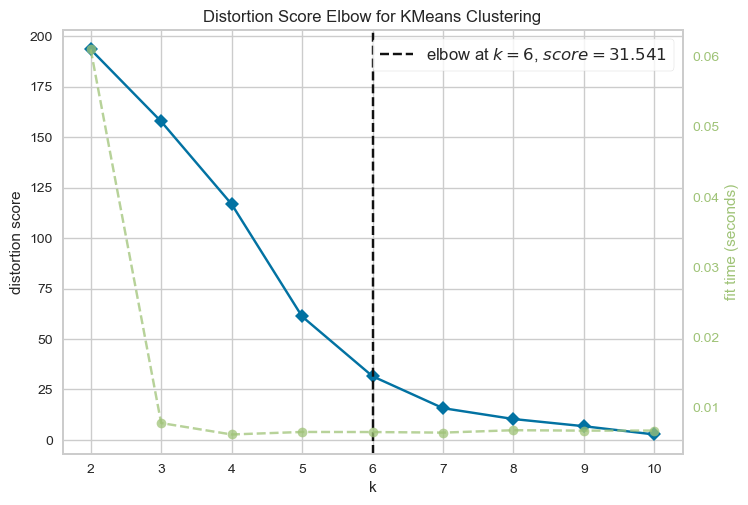

In [22]:
dataframe = df
dimred_columns = [col for col in dataframe.columns if col.startswith('pc')]
k = (3, 10)

clustering_algorithm = 'kMeans'

if clustering_algorithm == 'kMeans':
    elbow_method = kmeans_score(dataframe[dimred_columns], k)
    n_clust = elbow_method.elbow_value_
    print(f'Optimal number of clusters using distortion score (elbow plot): {n_clust}')
    elbow_method.show()

dimred_columns = [col for col in dataframe.columns if col.startswith('pc')]

kmeans_clustering = KMeans(n_clusters=n_clust, random_state=42, n_init=10)
kmeans_clustering.fit(dataframe[dimred_columns])

dataframe[f'{clustering_algorithm}_cluster'] = kmeans_clustering.labels_

In [23]:
dataframe = df
x_axis = 'pc1'
y_axis = 'pc2'

groupby = 'kMeans_cluster'  # name or 0-index for column to group data by
color = 'Category20'  # color palette for grouped data

save_plot = False
file_name = 'Clustered PCA Space'
file_path = run_date

plt = ''
plt = scatter_plot(dataframe, x=x_axis, y=y_axis, svgs=image_column, hover_list=[id_column], groupby=groupby, color=color, outline=color)

if save_plot:
    hv.save(plt, file_path + '/' + file_name + '.html', fmt='html')

plt

:Scatter   [pc1]   (pc2,Image,kMeans_cluster,ID)

# MLR Search

Note: best to incorporate additional validation scores (LOO, k-fold)

## First Step

In [24]:
dataframe = df[df['Split'] != 'external validation'].copy()
y_axis = response_column
threshold = 0.2  # threshold for features to retain (recommended to keep low unless you have many features/plan to run many steps)
hover_list = [id_column]

first_step_results = []  # list to store results of first step of MLR (formatted as [Training R^2, Training MAE, Validation R^2, Validation MAE], descriptor)
regression = linear_model.LinearRegression()
for d1 in descriptors:
    mlr_features = [d1]
    if 'internal validation' in list(dataframe['Split']):
        regression.fit(dataframe.loc[dataframe['Split'] == 'train', mlr_features], dataframe.loc[dataframe['Split'] == 'train', response_column])
    else:
        regression.fit(dataframe[mlr_features], dataframe[response_column])

    pred_y = regression.predict(dataframe[mlr_features])
    dataframe.loc[:, 'mlr prediction'] = pred_y
    train_r2 = r2_score(dataframe.loc[dataframe['Split'] == 'train', response_column], dataframe.loc[dataframe['Split'] == 'train', response_column], dataframe.loc[dataframe['Split'] == 'train', 'mlr prediction'])
    
    if train_r2 > threshold:
        validation_r2 = r2_score(dataframe.loc[dataframe['Split'] == 'train', response_column], dataframe.loc[dataframe['Split'] == 'internal validation', response_column], dataframe.loc[dataframe['Split'] == 'internal validation', 'mlr prediction'])
        train_mae = mean_absolute_error(dataframe.loc[dataframe['Split'] == 'train', response_column], dataframe.loc[dataframe['Split'] == 'train', 'mlr prediction'])
        
        if 'internal validation' in list(dataframe['Split']):
            validation_mae = mean_absolute_error(dataframe.loc[dataframe['Split'] == 'internal validation', response_column], dataframe.loc[dataframe['Split'] == 'internal validation', 'mlr prediction'])
            first_step_results.append([[train_r2, train_mae, validation_r2, validation_mae], d1])
        else: 
            validation_mae = None; first_step_results = None

first_step_results = sorted(first_step_results, key=lambda x: x[0][0], reverse=True); print(f'{len(first_step_results)} descriptors with R^2 > {threshold}')


10 descriptors with R^2 > 0.2


### Sort Results from First Step

In [25]:
sort_by = 'train r2'  # options are 'train r2', 'train mae', 'validation r2', 'validation mae'
models_to_print = 5  # number of models to print

# Define the sorting options and their respective indices and orders
sort_options = {
    'train r2': (0, 0, True),
    'train mae': (0, 1, False),
    'validation r2': (0, 2, True),
    'validation mae': (0, 3, False)
}

# Get the sorting parameters based on the selected option
sort_index, sort_subindex, sort_reverse = sort_options[sort_by]

# Sort the results based on the selected option
first_step_results = sorted(first_step_results, key=lambda x: x[sort_index][sort_subindex], reverse=sort_reverse)

# Print the top models
for model_stats, features in first_step_results[:models_to_print]:
    print(f'{features}:\n\tTraining R^2 = {model_stats[0]:.2f}, Validation R^2 = {model_stats[2]:.2f}\n\tTraining MAE = {model_stats[1]:.2f}, Validation MAE = {model_stats[3]:.2f}')

P_NMR_min:
	Training R^2 = 0.63, Validation R^2 = -1.31
	Training MAE = 13.34, Validation MAE = 38.79
aniso_P_NMR_max:
	Training R^2 = 0.63, Validation R^2 = -1.41
	Training MAE = 13.26, Validation MAE = 39.23
P_Pd_bond_eng_min:
	Training R^2 = 0.47, Validation R^2 = -0.65
	Training MAE = 16.27, Validation MAE = 30.65
Pd_NBO:
	Training R^2 = 0.44, Validation R^2 = 0.21
	Training MAE = 16.32, Validation MAE = 22.64
Homo:
	Training R^2 = 0.40, Validation R^2 = -0.16
	Training MAE = 17.65, Validation MAE = 25.95


## Second Step

In [26]:
dataframe = df[df['Split'] != 'external validation'].copy()
y_axis = response_column
threshold = 0.2  # threshold for features to retain (recommended to keep low unless you have many features/plan to run many steps)
hover_list = [id_column]

second_step_results = []  # list to store results of first step of MLR (formatted as [Training R^2, Training MAE, Validation R^2, Validation MAE], descriptor)
regression = linear_model.LinearRegression()
for model_stats, d1 in first_step_results:
    for d2 in descriptors:
        if d1 != d2:
            mlr_features = [d1, d2]
            if 'internal validation' in list(dataframe['Split']):
                regression.fit(dataframe.loc[dataframe['Split'] == 'train', mlr_features], dataframe.loc[dataframe['Split'] == 'train', response_column])
            else:
                regression.fit(dataframe[mlr_features], dataframe[response_column])

            pred_y = regression.predict(dataframe[mlr_features])
            dataframe.loc[:, 'mlr prediction'] = pred_y
            train_r2 = r2_score(dataframe.loc[dataframe['Split'] == 'train', response_column], dataframe.loc[dataframe['Split'] == 'train', response_column], dataframe.loc[dataframe['Split'] == 'train', 'mlr prediction'])
            
            if train_r2 > threshold:
                train_mae = mean_absolute_error(dataframe.loc[dataframe['Split'] == 'train', response_column], dataframe.loc[dataframe['Split'] == 'train', 'mlr prediction'])
                
                if 'internal validation' in list(dataframe['Split']):
                    validation_r2 = r2_score(dataframe.loc[dataframe['Split'] == 'train', response_column], dataframe.loc[dataframe['Split'] == 'internal validation', response_column], dataframe.loc[dataframe['Split'] == 'internal validation', 'mlr prediction'])
                    validation_mae = mean_absolute_error(dataframe.loc[dataframe['Split'] == 'internal validation', response_column], dataframe.loc[dataframe['Split'] == 'internal validation', 'mlr prediction'])
                else: 
                    validation_r2 = None; validation_mae = None
                
                second_step_results.append([[train_r2, train_mae, validation_r2, validation_mae], d1, d2])

second_step_results = sorted(second_step_results, key=lambda x: x[0][0], reverse=True); print(f'{len(second_step_results)} two parameter models with R^2 > {threshold}')


230 two parameter models with R^2 > 0.2


### Sort Results from Second Step

In [27]:
sort_by = 'validation r2'  # options are 'train r2', 'train mae', 'validation r2', 'validation mae'
models_to_print = 5  # number of models to print

# Define the sorting options and their respective indices and orders
sort_options = {
    'train r2': (0, 0, True),
    'train mae': (0, 1, False),
    'validation r2': (0, 2, True),
    'validation mae': (0, 3, False)
}

# Get the sorting parameters based on the selected option
sort_index, sort_subindex, sort_reverse = sort_options[sort_by]

# Sort the results based on the selected option
second_step_results = sorted(second_step_results, key=lambda x: x[sort_index][sort_subindex], reverse=sort_reverse)

# Print the top models
for model_stats, d1, d2 in second_step_results[:models_to_print]:
    print(f'{d1}, {d2}:\n\tTraining R^2 = {model_stats[0]:.2f}, Validation R^2 = {model_stats[2]:.2f}\n\tTraining MAE = {model_stats[1]:.2f}, Validation MAE = {model_stats[3]:.2f}')

Vbur%_3.0_Ang, R_B1_min:
	Training R^2 = 0.48, Validation R^2 = 0.94
	Training MAE = 17.01, Validation MAE = 4.95
Vbur%_3.0_Ang, aniso_P_NMR_min:
	Training R^2 = 0.93, Validation R^2 = 0.92
	Training MAE = 6.21, Validation MAE = 6.58
aniso_P_NMR_min, Vbur%_3.0_Ang:
	Training R^2 = 0.93, Validation R^2 = 0.92
	Training MAE = 6.21, Validation MAE = 6.58
Vbur%_3.0_Ang, P_NBO_min:
	Training R^2 = 0.56, Validation R^2 = 0.92
	Training MAE = 14.76, Validation MAE = 5.41
Vbur%_3.0_Ang, NoPd_aniso_P_NMR_min:
	Training R^2 = 0.41, Validation R^2 = 0.90
	Training MAE = 15.53, Validation MAE = 8.02


## Visualize MLR Plot

In [28]:
dataframe = df[df['Split'] != 'external validation'].copy()
features = ['Vbur%_3.0_Ang', 'aniso_P_NMR_min']
y_axis = response_column
hover_list = [id_column]  # list of column names with data to be shown on hover


save_plot = False
file_name = f'{response_column} vs. {", ".join(features)}'
file_path = run_date

x_label = f'{response_column}'
y_label = f'Predicted {response_column}'
title = f'{y_label} vs {x_label}'

regression = linear_model.LinearRegression()
regression.fit(dataframe[features], dataframe[response_column])
dataframe['mlr prediction'] = regression.predict(dataframe[features])
coefficients = regression.coef_; intercept = regression.intercept_

terms = [f'({round(coef, 3)} * {desc})' for coef, desc in zip(coefficients, features)]
model_equation = f'{response_column} = {round(regression.intercept_, 3)} + ' + ' ' + ' + '.join(terms)

all_scatter_plt = scatter_plot(dataframe, x=response_column, y='mlr prediction', svgs=image_column, hover_list=hover_list, x_label=x_label, y_label=y_label, title=title, color='#7291ab', alpha=0)
train_scatter_plt = scatter_plot(dataframe[dataframe['Split']=='train'], x=response_column, y='mlr prediction', svgs=image_column, hover_list=hover_list, x_label=x_label, y_label=y_label, title=title, color='#60a9e6', alpha=0.8)
if 'internal validation' in list(dataframe['Split']):
    validation_scatter_plt = scatter_plot(dataframe[dataframe['Split']=='internal validation'], x=response_column, y='mlr prediction', svgs=image_column, hover_list=hover_list, x_label=x_label, y_label=y_label, title=title, color='#0d263b', alpha=0.8)
else:
    validation_scatter_plt = all_scatter_plt

slope, r_value = plot_slope(dataframe[dataframe['Split']=='train'], x=response_column, y='mlr prediction', x_label=x_label, y_label=y_label)
confidence_interval = plot_confidenceinterval(dataframe, x=response_column, y='mlr prediction')  # Planning to change confidence interval to prediction interval, more meaningful (also ci may be too narrow than what it should be)

train_r2 = r2_score(dataframe.loc[dataframe['Split'] == 'train', response_column], dataframe.loc[dataframe['Split'] == 'train', response_column], dataframe.loc[dataframe['Split'] == 'train', 'mlr prediction'])
train_mae = mean_absolute_error(dataframe.loc[dataframe['Split'] == 'train', response_column], dataframe.loc[dataframe['Split'] == 'train', 'mlr prediction'])            
                
if 'internal validation' in list(dataframe['Split']):
    validation_r2 = r2_score(dataframe.loc[dataframe['Split'] == 'train', response_column], dataframe.loc[dataframe['Split'] == 'internal validation', response_column], dataframe.loc[dataframe['Split'] == 'internal validation', 'mlr prediction'])
    validation_mae = mean_absolute_error(dataframe.loc[dataframe['Split'] == 'internal validation', response_column], dataframe.loc[dataframe['Split'] == 'internal validation', 'mlr prediction'])
else: 
    validation_r2 = None; validation_mae = None

print(model_equation)
print(f'Training R^2 = {train_r2:.2f}, Validation R^2 = {validation_r2:.2f}')
print(f'Training MAE = {train_mae:.2f}, Validation MAE = {validation_mae:.2f}')

plt = train_scatter_plt * validation_scatter_plt * slope * confidence_interval
plt = all_scatter_plt * plt

if save_plot:
    hv.save(plt, file_path + '/' + file_name + '.html', fmt='html')

plt



Yield = 66.984 +  (22.363 * Vbur%_3.0_Ang) + (18.795 * aniso_P_NMR_min)
Training R^2 = 0.93, Validation R^2 = 0.95
Training MAE = 6.11, Validation MAE = 5.29


:Overlay
   .Scatter.I    :Scatter   [Yield]   (mlr prediction,Image,ID)
   .Scatter.II   :Scatter   [Yield]   (mlr prediction,Image,mlr prediction,Image,ID)
   .Scatter.III  :Scatter   [Yield]   (mlr prediction,Image,mlr prediction,Image,mlr prediction,Image,ID)
   .Annotation.I :Slope   [x,y]
   .Area.I       :Area   [x]   (ci_y1,ci_y2)

# Other Interactive Plots

### Categorical Coloring (user defined colors and labels, in contrast to cluster plotting method above)

In [29]:
dataframe = df
x_axis = 'pc1'
y_axis = 'pc2'

category_column = 'R_Selective'  # name or 0-index for column containing category criteria
category_criteria = {  # column value: [label, color] (column value can be string or integer)
    0 : ['S Selective', '#a7c2db'],
    1 : ['R Selective', '#fabc7a'],
}

save_plot = False
file_name = 'Selectivity Data in PCA Space'
file_path = run_date

plt = None
for key, value in category_criteria.items():
    legend = value[0]
    color = value[1]
    if plt:
        subplt = scatter_plot(dataframe.loc[dataframe[category_column] == key], x=x_axis, y=y_axis, legend=legend, svgs=image_column, hover_list=[id_column], color=color, outline=color, alpha=1)
        plt = plt * subplt
    else:
        plt = scatter_plot(dataframe.loc[dataframe[category_column] == key], x=x_axis, y=y_axis, legend=legend, svgs=image_column, hover_list=[id_column], color=color, outline=color, alpha=1)
base_plt = scatter_plot(dataframe, x=x_axis, y=y_axis, svgs=image_column, hover_list=[id_column], alpha=0)  # add svg hover info to all layers (default is bottom plt only)
plt = base_plt * plt

if save_plot:
    hv.save(plt, file_path + '/' + file_name + '.html', fmt='html')

plt

:Overlay
   .Scatter.I           :Scatter   [pc1]   (pc2,Image,ID)
   .Scatter.S_Selective :Scatter   [pc1]   (pc2,Image,ID)
   .Scatter.R_Selective :Scatter   [pc1]   (pc2,Image,ID)

### Heatmap

In [30]:
dataframe = df
x_axis = 'pc1'
y_axis = 'pc2'
color_col = response_column
heatmap_color = 'Plasma'
title = f'{y_axis} vs {x_axis} colored by {color_col}'
hover_list = [id_column]

save_plot = False
file_name = f'pca heatmap colored by {color_col}'
file_path = run_date

plt = scatter_plot(dataframe, x=x_axis, y=y_axis, title=title, svgs=image_column, hover_list=hover_list, heatmap=True, heatmap_col=color_col, heatmap_color=heatmap_color, alpha=0.8)


if save_plot:
    hv.save(plt, file_path + '/' + file_name + '.html', fmt='html')

plt

:Scatter   [pc1]   (pc2,Image,ID,Yield)

### Bubble Plot

Note: this may have issues with size if using unscaled features (to be fixed in the future)

In [31]:

dataframe = df
x_axis = 'pc1'
y_axis = 'pc2'  
size_col = 'Vbur%_3.0_Ang'  # name or 0-index for column to size data by
title = f'PCA, sized by {color_col}'
hover_list = [id_column]

save_plot = False
file_name = 'pca all'
file_path = run_date

plt = scatter_plot(dataframe, x=x_axis, y=y_axis, title=title, svgs=image_column, hover_list=hover_list, bubbleplot=True, bubblesize=size_col, alpha=0.8)


if save_plot:
    hv.save(plt, file_path + '/' + file_name + '.html', fmt='html')

plt

:Scatter   [pc1]   (pc2,Image,ID,Vbur%_3.0_Ang)

### Heatmap Bubble Plot

In [32]:
dataframe = df
x_axis = 'pc1'
y_axis = 'pc2'
color_col = response_column
heatmap_color = 'Plasma'
size_col = 'Vbur%_3.0_Ang'
hover_list = [id_column]

save_plot = False
file_name = 'pca all'
file_path = run_date

plt = scatter_plot(dataframe, x=x_axis, y=y_axis, svgs=image_column, hover_list=hover_list, heatmap=True, heatmap_col=color_col, heatmap_color=heatmap_color, bubbleplot=True, bubblesize=size_col, alpha=0.8)

if save_plot:
    hv.save(plt, file_path + '/' + file_name + '.html', fmt='html')

plt

:Scatter   [pc1]   (pc2,Image,ID,Yield,Vbur%_3.0_Ang)